In [79]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from collections import Counter
import nltk
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns

class Problem():
    def __init__(self, data):
        self.problem = data['problem']
        try: self.level = re.search(r'\d', data['level'])[0]
        except: self.level = None
        self.type =  data['type']
        self.solution = data['solution']
        self.problem_numbers = self.count_numbers(self.problem)
        self.solution_numbers = self.count_numbers(self.solution)

    def count_numbers(self,s):
        return len(re.findall(r'\d+', s))
    
    def __str__(self):
        return str({"problem": self.problem, "level": self.level, "type": self.type, "solution": self.solution})
    
    def __repr__(self):
        return self.__str__()

# Exploring the MATH Dataset

## Introduction
Have you ever looked at a Math problem and had no clue on how to solve it? It might be possible that if different types of problems can be clustered into different groups of similar problems, then that might provide some insight on if the problems can be solved in similar ways. Also, when it comes to numbers and math problems, Natural Language Processing (NLP) tools such as Large Language Models (LLMs) can struggle. So, it is interesting to look at a collection of data that might be difficult for LLMs to solve to see if any other insight can be gain from trends within the data. 

The MATH dataset contains 12,500 problems from different U.S. math competitions such as AMC, AIME, Putnam, and more. Each problem in the dataset contains information including the problem's text, the solution, the subject of the problem, and the difficulty of the problem. The possible subjects for the problems include Prealgebra, Algebra, Number Theory, Counting and Probability, Geometry, Intermediate Algebra,
and Precalculus. 

Most of our code is hidden in this report for readability, but to get an idea of our dataset, here is a peak the code for loading the dataset:

In [ ]:
class Problem():
    def __init__(self, data):
        self.problem = data['problem']
        try: self.level = re.search(r'\d', data['level'])[0]
        except: self.level = None
        self.type =  data['type']
        self.solution = data['solution']
        self.problem_numbers = self.count_numbers(self.problem)
        self.solution_numbers = self.count_numbers(self.solution)

    def count_numbers(self,s):
        return len(re.findall(r'\d+', s))
    
    def __str__(self):
        return str({"problem": self.problem, "level": self.level, "type": self.type, "solution": self.solution})
    
    def __repr__(self):
        return self.__str__()

And here is a distribution of subjects among all the problems:

In [64]:
path_to_train = "../MATH/train"

problems = []

for root, dirs, files in os.walk(path_to_train):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith(".json"):
            with open(file_path, "r") as f:
                problems.append(Problem(json.load(f)))

path_to_test = "../MATH/test/"

test_problems = []

for root, dirs, files in os.walk(path_to_test):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith(".json"):
            with open(file_path, "r") as f:
                test_problems.append(Problem(json.load(f)))

test_categories = [prob.type for prob in test_problems]
test_difficulty = [prob.level for prob in test_problems]
test_problem_text = [' '.join(prob.problem.lower().replace(".", "").replace("?", "").replace(",", "").split()) for prob in test_problems]

levels = [problem.level for problem in problems]
levels = [level for level in levels if level is not None]
level_counts = {level: levels.count(level) for level in set(levels)}
sorted_level_counts = dict(sorted(level_counts.items(), key=lambda x: x[1]))

types = [problem.type for problem in problems]
type_counts = {type: types.count(type) for type in types}
sorted_type_counts = dict(sorted(type_counts.items(), key=lambda x: x[1]))


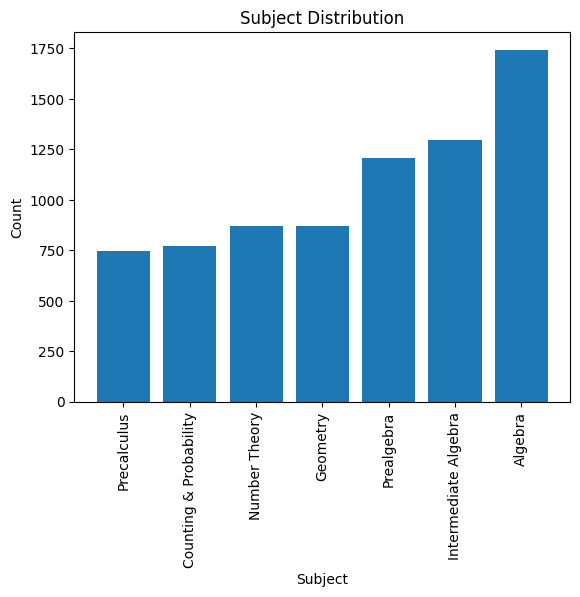

In [66]:
plt.bar(sorted_type_counts.keys(), sorted_type_counts.values())
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Subject Distribution')
plt.show()

The difficulty of the problems range from 1 to 5. This difficulty rating is given by Art of Problem Solving (AoPS). AoPS takes into account that some subjects may be more difficult than others, so the difficulty is in the scope of the subject. Here is a distribution of difficulty among all the problems:

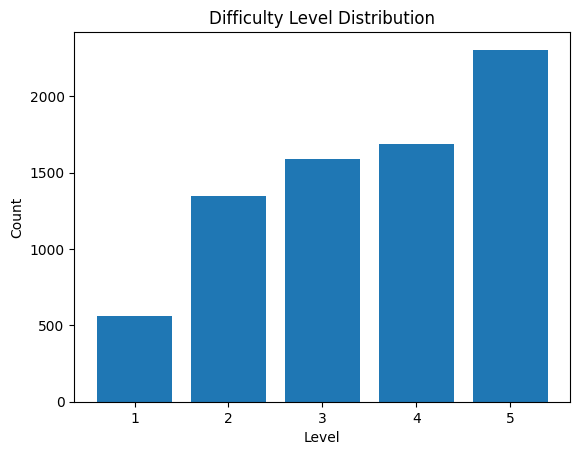

In [67]:
plt.bar(sorted_level_counts.keys(), sorted_level_counts.values())
plt.xlabel('Level')
plt.ylabel('Count')
plt.title('Difficulty Level Distribution')
plt.show()

Here are the distributions of difficulty for each subject:

In [51]:

subjects = list(set(types))

level_counts_by_subject = {subject: [] for subject in subjects}

for subject in subjects:
    subject_levels = [problem.level for problem in problems if problem.type == subject]
    subject_level_counts = Counter(subject_levels)
    for level in sorted_level_counts.keys():
        level_counts_by_subject[subject].append(subject_level_counts[level])

level_counts_array = np.array(list(level_counts_by_subject.values()))

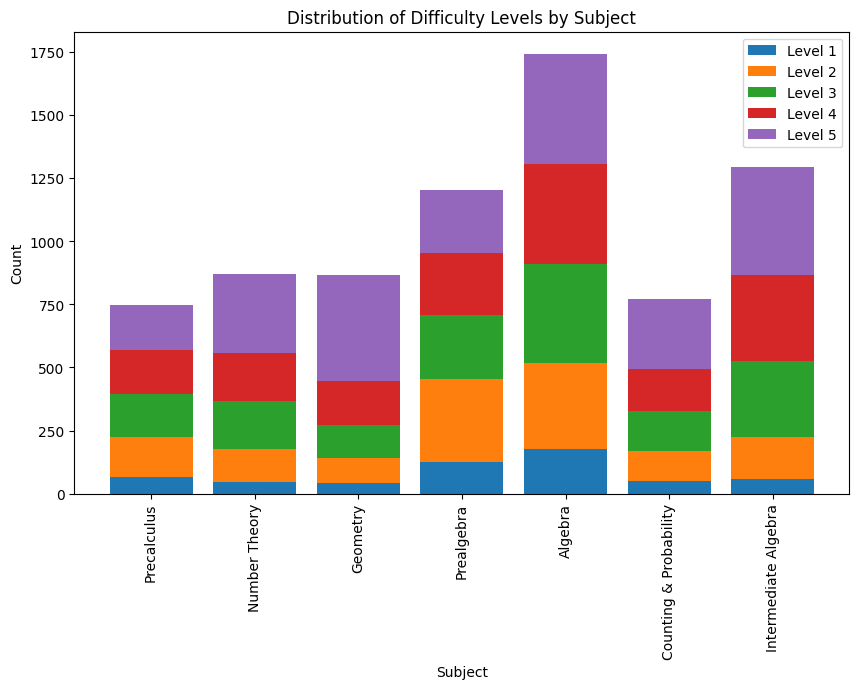

In [53]:
plt.figure(figsize=(10, 6))
plt.bar(subjects, level_counts_array[:, 0], label='Level 1')
plt.bar(subjects, level_counts_array[:, 1], bottom=level_counts_array[:, 0], label='Level 2')
plt.bar(subjects, level_counts_array[:, 2], bottom=level_counts_array[:, 0] + level_counts_array[:, 1], label='Level 3')
plt.bar(subjects, level_counts_array[:, 3], bottom=level_counts_array[:, 0] + level_counts_array[:, 1] + level_counts_array[:, 2], label='Level 4')
plt.bar(subjects, level_counts_array[:, 4], bottom=level_counts_array[:, 0] + level_counts_array[:, 1] + level_counts_array[:, 2] + level_counts_array[:, 3], label='Level 5')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.title('Distribution of Difficulty Levels by Subject')
plt.legend()
plt.xticks(rotation=90)
plt.show()

We can see that overall among all the problems and with each subject, the distribution is not a normal distribution. So, this must be taking into account when doing later analysis of the future outcomes.

To analyze the trends, we want to see if the subject of the problem or the difficulty of the problem can be predicted based on the content of the problem statement.

## Methods

Some content trends we plan to initially explore are the predictability of the subject or difficulty using content such as the magnitude of numbers, the amount of numbers, or the words in the problem statement. 

### Exploring Numbers

For content like the magnitude of numbers and the amount of numbers, we plan to plot a distribution in order to see if there are clear delinations between the subjects and the difficulties of problems. 

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


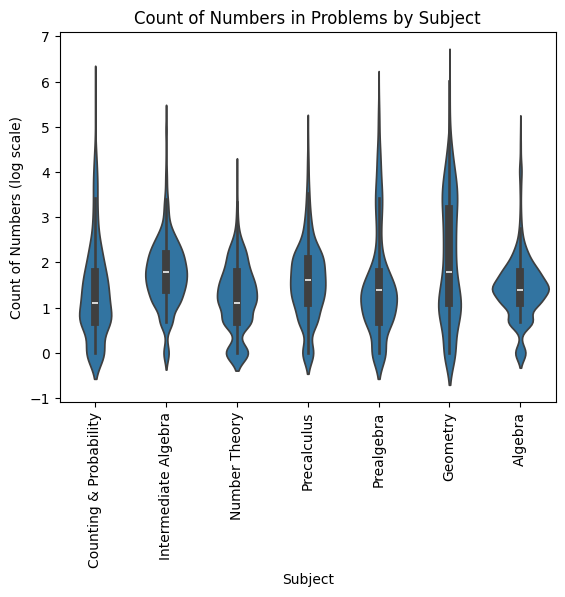

In [106]:
types = [problem.type for problem in problems]
numbers = [problem.problem_numbers for problem in problems]
df = pd.DataFrame({'type': types, 'numbers': numbers})

df['numbers'] = np.log(df['numbers'])

sns.violinplot(x='type', y='numbers', data=df)
plt.xticks(rotation=90)
plt.xlabel('Subject')
plt.ylabel('Count of Numbers (log scale)')
plt.title('Count of Numbers in Problems by Subject')
plt.show()

### Exploring Words

For content like the words, we plan to do an initial analysis by looking at the most common words between subjects and difficulties. After this, we can develop a better hypothesis for the predictabilty, then use a machine learning (ML) approach to determine the predictability of the subject or the difficulty. This ML approach would be through the use of a Multinomial Naive Bayes algorithm.

#### Initial Exploration

An introductory tool we can use for exploration of the subjects and difficulties are the most common words in each respective section. If see a some words appearing more than others in the different sections, then we can hypothesize that the section may perform well in getting predicted. When it comes to math problems, there can are lots of stop words and operations such as +, -, /, *, ^, etc. These elements may be useful or harmful for the prediction of the section, so we can explore the diversity between the most common words in the section with and without these elements.

Here is the most common words per section using all of the data:

In [11]:
# Input code for most common 5 or 10 words from each subject category and for each difficulty category

Here is the most common words per section with stopwords removed:

In [12]:
# Input code for most common 5 or 10 words from each subject category and for each difficulty category

Here is the most common words per section with operations removed:

In [13]:
# Input code for most common 5 or 10 words from each subject category and for each difficulty category

Here is the most common words per section with both removed:

In [14]:
# Input code for most common 5 or 10 words from each subject category and for each difficulty category

#### Initial Analysis and Hypotheses
\* Analysis once data is seen *

#### Multinomial Naive Bayes (MNB)

A Multinomial Naive Bayes model is a probabilistic NLP model that takes in tokens and their counts, then calculates the probability for outcomes to classify discrete classification problems. The probability for the different tokens are classified using the formula.

$$
P(A|B)=\frac{P(B|A)*P(A)}{P(B)}
$$

In order to set up the tokens and the counts for the Multinomial Naive Bayes model, we used a count vectorizer to turn the math problem statements into token counts.

In [15]:
# Code for setting up Count Vectorizer

With the token vectorizer, we had the flexibility to choose the minimum amount of problems that a token had to be in and the maximum number of problems to be in. We worked on hypertuning the parameters from a minimum problem count between *insert min and max* to a maximum problem count between *insert min and max*. After hypertuning these parameters and using the counts on the MNB model, we ended up with the best parameters being *insert best* for the subjects and *insert* for the difficulties.

Here is the code for the best MNB model on the subjects:

In [16]:
# Code for MNB model with the best parameters on subjects

In [17]:
# Visualization of confusion matrix

Here is the code for the best MNB model on the difficulties:

In [18]:
# Code for MNB model with the best parameters on difficulties

In [19]:
# Visualization of confusion matrix

\* Analysis of confusion matrices *

## Conclusion